In [ ]:
COLAB = True

if COLAB: 
  from google.colab import drive
  drive.mount('/content/drive/')
  !unzip src.zip
  !mkdir data && mkdir data/models
  !pip install audiomentations
  speech_path, save_path = "drive/MyDrive/audio-pattern", "drive/MyDrive/audio-pattern"
else:
  speech_path, save_path = "data/raw/speech", "data/processed"

In [2]:
from src.data_processing import FeatureExtractor
from src.dataset import Dataset
from src.loader import Loader, Augmenter
from src.models import build_train_simple, train_nn, build_nn, build_cnn, build_lstm

from audiomentations import AddGaussianNoise, TimeStretch, PitchShift
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as Dtree

import seaborn as sns
sns.set_theme()

import numpy as np
from numpy.random import seed
seed(1)

import tensorflow
tensorflow.random.set_seed(1)

import warnings  
warnings.filterwarnings("ignore")

In [3]:
COMPUTE_AUGMENT = False

loader = Loader(speech_path, save_path, True, 116247, -1)
orig_data, orig_labels = loader.load(False)

In [4]:
# original features
orig_features, orig_labels = FeatureExtractor(raw_data=orig_data, labels=orig_labels, 
                                              save_path=f"{save_path}/features", 
                                              file_name="full", verbose=True, 
                                              only_mfcc=False).get_training_data(overwrite=False)

orig_features_mfcc, orig_labels_mfcc = FeatureExtractor(raw_data=orig_data, labels=orig_labels, 
                                                        save_path=f"{save_path}/features", 
                                                        file_name="mfcc", verbose=True, 
                                                        only_mfcc=True).get_training_data(overwrite=False)
orig_features_mfcc = np.expand_dims(orig_features_mfcc, axis=2)

Filename: full found on disk

Filename: mfcc found on disk



In [6]:
# define augmenters
speed = TimeStretch(min_rate=0.6, max_rate=1.4, p=1)
noise = AddGaussianNoise(min_amplitude=0.0005, max_amplitude=0.002, p=1)
pitch = PitchShift(min_semitones=-4, max_semitones=4, p=1)

augmented_data_full = []
augmented_data_mfcc = []

for a, name in zip([speed, noise, pitch], ["speed", "noise", "pitch"]):
    # augment the data
    augmenter = Augmenter(loader, a)
    aug_data = None
    labels = orig_labels
    if COMPUTE_AUGMENT:
      aug_data, labels = augmenter.augment()
    
    # extract all features
    full_data, full_labels = FeatureExtractor(raw_data=aug_data, labels=labels, 
                              save_path=f"{save_path}/features", 
                              file_name=f"full_augmented_{name}", verbose=True, 
                              only_mfcc=False).get_training_data(overwrite=False)
    augmented_data_full.append((full_data, full_labels))
    
    # extract mfcc for cnn
    mfcc_data, mfcc_labels = FeatureExtractor(raw_data=aug_data, labels=labels, 
                              save_path=f"{save_path}/features", 
                              file_name=f"mfcc_augmented_{name}", verbose=True, 
                              only_mfcc=True).get_training_data(overwrite=False)
    mfcc_data = np.expand_dims(mfcc_data, axis=2)
    augmented_data_mfcc.append((mfcc_data, mfcc_labels))

Filename: full_augmented_speed found on disk

Filename: mfcc_augmented_speed found on disk

Filename: full_augmented_noise found on disk

Filename: mfcc_augmented_noise found on disk

Filename: full_augmented_pitch found on disk

Filename: mfcc_augmented_pitch found on disk



In [7]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=augmented_data_full)
X_train, X_test, y_train, y_test = d.get_training_data(label="emotion", train_perc=0.7)

In [8]:
k = int(len(X_train)**0.5)
scores = []
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), SVC()))
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), KNN(k)))
scores.append(build_train_simple((X_train, y_train), (X_test, y_test), Dtree(max_depth=10)))

print("Simple models scores on test:\n")
print("\n".join([f"\t- {a:5} : {b:0.3f}" for a, b in zip(["Svc", "Knn", "Dtree"], scores)]))

Simple models scores on test:

	- Svc   : 0.631
	- Knn   : 0.414
	- Dtree : 0.428


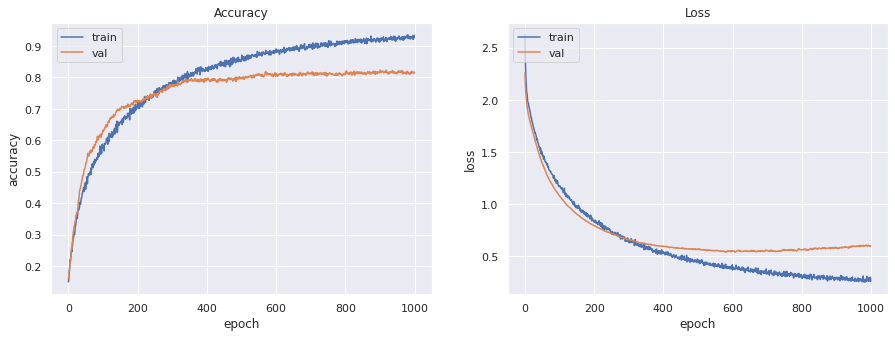

In [9]:
nn_scores = []
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_nn, epochs=1000, verbose=0, plot=True)[1])

In [10]:
d = Dataset(original_data=(orig_features_mfcc, orig_labels_mfcc), augmented_data=augmented_data_mfcc)
X_train, X_test, y_train, y_test = d.get_training_data(label="emotion", train_perc=0.7)

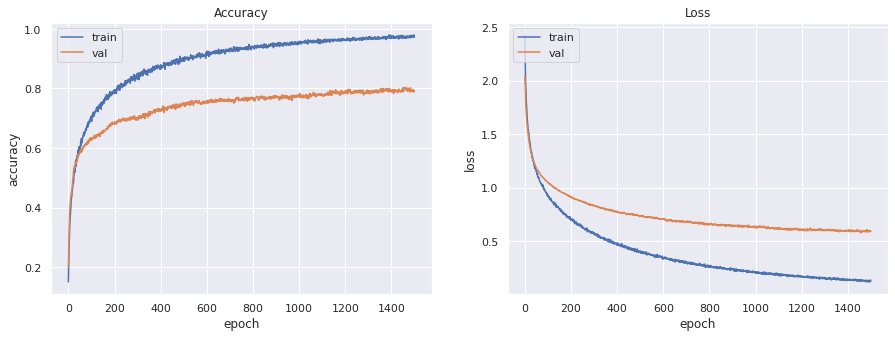

In [11]:
nn_scores.append(train_nn((X_train, y_train), (X_test, y_test), build_cnn, epochs=1500, verbose=0, plot=True)[1])

In [12]:
print("Neural networks scores on test:\n")
print("\n".join([f"\t- {a:5} : {b:0.3f}" for a, b in zip(["MLP", "CNN"], nn_scores)]))

Neural networks scores on test:

	- MLP   : 0.659
	- CNN   : 0.668
